# Import Packages

In [75]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
from pandas_datareader import data as pdr
from faker import Faker
import matplotlib.pyplot as plt
import ta
import datetime

Set Date Range

In [76]:
fake = Faker()
start_date = fake.date_between(start_date=datetime.date(2010,1,1), end_date='now')
end_date = fake.date_between(start_date=start_date, end_date='now')

start_date=datetime.date(2015,1,1)
end_date=datetime.date(2017,1,1)


#df = yf.Ticker("SPY").history(period = '3y', interval = '1d').reset_index()[["Date", "Close"]]
df = pdr.get_data_yahoo("SPY", start=start_date,  end=end_date).reset_index()[["Date", "Close"]]

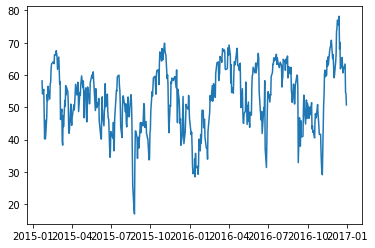

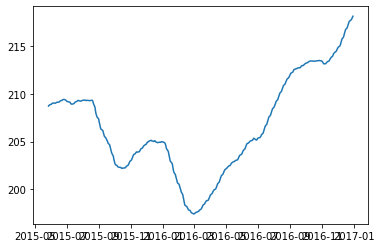

In [77]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window = 14).rsi()
plt.plot(df['Date'], df['RSI'])
plt.show()


df['EMA100'] = ta.trend.EMAIndicator(df['Close'], window = 100).ema_indicator()
plt.plot(df['Date'], df['EMA100'])
plt.show()

df['EMA200'] = ta.trend.EMAIndicator(df['Close'], window = 200).ema_indicator()

In [78]:
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['Signal'] = ta.trend.MACD(df['Close']).macd_signal()
df['MACD_Diff'] = ta.trend.MACD(df['Close']).macd_diff()
df


,Date,Close,RSI,EMA100,EMA200,MACD,Signal,MACD_Diff
0,2015-01-02,205.429993,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,201.720001,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,199.820007,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,202.309998,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,205.899994,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
499,2016-12-23,225.710007,61.645713,217.629897,213.839994,2.089612,2.324932,-0.235320
500,2016-12-27,226.270004,63.379168,217.800989,213.963675,2.021524,2.264250,-0.242726
501,2016-12-28,224.399994,54.518172,217.931662,214.067519,1.795968,2.170594,-0.374626
502,2016-12-29,224.350006,54.299629,218.058758,214.169833,1.594795,2.055434,-0.460639


Strategy 1: Pure MACD

In [79]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
stoploss = None
max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= max_profit:
        if adaptive_stoploss:
            stoploss = df.Close[i] * 0.99
            max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            stoploss = None
            max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        stoploss = df.Close[i] * 0.99
        max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Buy at $", df.Close[i])
            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == True:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False
        if debug:
            print("Momentum Changed - Sell at $", df.Close[i])
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) - len(Sells) == 1:
    Buys = Buys[:-1]
    
profit1 = sum(Sells) - sum(Buys)
print('Profit: ', profit1)


Profit:  -8.6400146484375


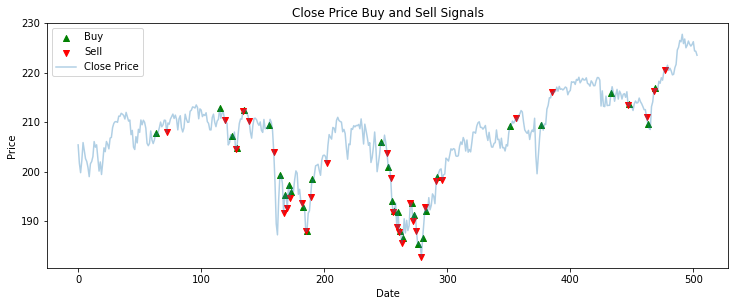

In [80]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

Strategy 2 MACD + EMA100

In [81]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
stoploss = None
max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= max_profit:
        if adaptive_stoploss:
            stoploss = df.Close[i] * 0.99
            max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            stoploss = None
            max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False and df.Close[i] > df.EMA100[i]:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        stoploss = df.Close[i] * 0.99
        max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Buy at $", df.Close[i])
            
    elif ( df.Close[i] < df.EMA100[i] or df.MACD_Diff[i] < df.Signal[i] ) and buy == True:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False
        if debug:
            print("Momentum Changed - Sell at $", df.Close[i])
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) - len(Sells) == 1:
    Buys = Buys[:-1]

profit2 = sum(Sells) - sum(Buys)
print('Profit: ', profit2)


Profit:  3.5999603271484375


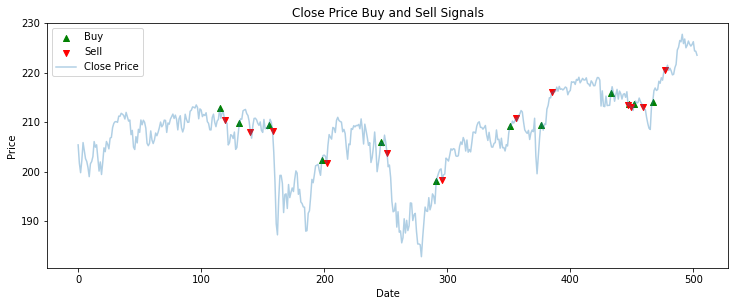

In [82]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

Strategy 3: MACD + RSI (Used to indicated Overbought or Oversold)

In [83]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
stoploss = None
max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= max_profit:
        if adaptive_stoploss:
            stoploss = df.Close[i] * 0.99
            max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            stoploss = None
            max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False and df.RSI[i] < 30:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        stoploss = df.Close[i] * 0.99
        max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Buy at $", df.Close[i])
            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == True:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False
        if debug:
            print("Momentum Changed - Sell at $", df.Close[i])
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) - len(Sells) == 1:
    Buys = Buys[:-1]

profit3 = sum(Sells) - sum(Buys)
print('Profit: ', profit3)

Profit:  12.58001708984375


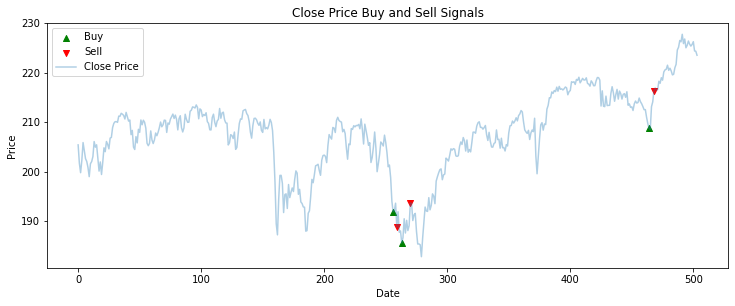

In [84]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

Strategy 4 MACD + RSI(Used as Trend)

In [85]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
stoploss = None
max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= max_profit:
        if adaptive_stoploss:
            stoploss = df.Close[i] * 0.99
            max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            stoploss = None
            max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False and df.RSI[i] > 50:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        stoploss = df.Close[i] * 0.99
        max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Buy at $", df.Close[i])
            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == True:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False
        if debug:
            print("Momentum Changed - Sell at $", df.Close[i])
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) - len(Sells) == 1:
    Buys = Buys[:-1]

profit4 = sum(Sells) - sum(Buys)
print('Profit: ', profit4)

Profit:  1.80999755859375


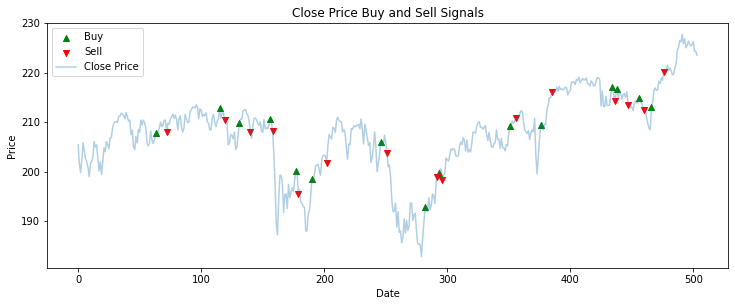

In [86]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

Result Comparison

Strategy 5 : RSI + MACD + EMA

In [100]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
stoploss = None
max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= max_profit:
        if adaptive_stoploss:
            stoploss = df.Close[i] * 0.99
            max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            stoploss = None
            max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
        
    elif (df.RSI[i] < 20 or df.MACD_Diff[i] > df.Signal[i]) and (df.Close[i] > df.EMA100[i] or df.RSI[i] > 50) and buy == False:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        stoploss = df.Close[i] * 0.98
        max_profit = df.Close[i] * 1.05
        buy = True
        if debug:
            print("Buy at $", df.Close[i])
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) - len(Sells) == 1:
    Buys = Buys[:-1]

profit5 = sum(Sells) - sum(Buys)
print('Profit: ', profit5)

Profit:  5.2599945068359375


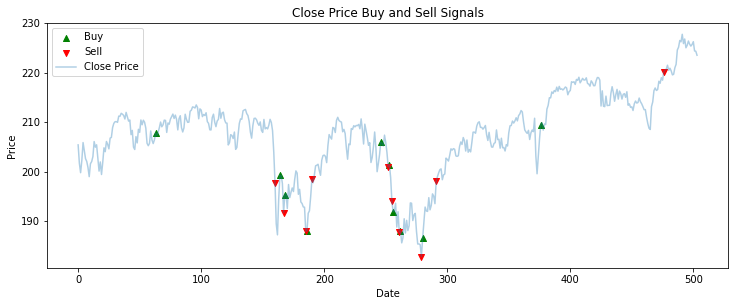

In [88]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

https://www.youtube.com/watch?v=Gs-_tleyz3Q

Comparison : With Sell option

In [89]:
print(start_date, end_date)
print('Pure MACD', profit1)
print('MACD + EMA100', profit2)
print('MACD + RSI (Oversold)', profit3)
print('MACD + RSI (Trend)', profit4)
print('MACD', profit5)


2015-01-01 2017-01-01
Pure MACD -8.6400146484375
MACD + EMA100 3.5999603271484375
MACD + RSI (Oversold) 12.58001708984375
MACD + RSI (Trend) 1.80999755859375
MACD -14.020004272460938
